<a id="up"></a>

## Прогнозирование заказов такси

### Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

### Задачи исследования

### [1. Загрузите данные и выполните их ресемплирование по одному часу. ](#1)

### [2. Проанализируйте данные.](#2)

### [3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.](#3)

### [4. Проверьте данные на тестовой выборке и сделайте выводы.](#4)

### Описание данных

Количество заказов находится в столбце `'num_orders'`(от англ. number of orders, «число заказов»).

<a id="1"></a>

### 1. Загрузим данные и выполним их ресемплирование по одному часу.

In [39]:
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
import numpy as np
import datetime


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import fbeta_score, make_scorer


import warnings
warnings.filterwarnings("ignore")

In [40]:
try:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except Exception as e:
    print(e)
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [41]:
df.sort_index(inplace=True) #выполним ресемплирование данных по одному часу.

df = df.resample('1H').sum()

In [42]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [44]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [45]:
df.isna().sum()

num_orders    0
dtype: int64

##### Вывод:
- загрузили данные и выполнили их ресемплирование по одному часу
- пропусков нет
- всего один признак - кол-во заказов

<a id="2"></a>

### 2. Анализ данных.

<AxesSubplot:xlabel='datetime'>

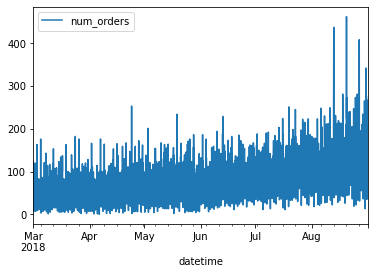

In [46]:
df.plot() # график ресемплированных данных

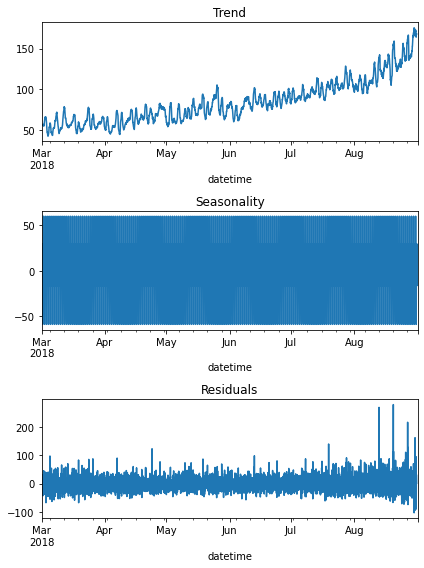

In [47]:
decomposed = seasonal_decompose(df) # разложим временной ряд на тренд и сезонную компоненту
plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

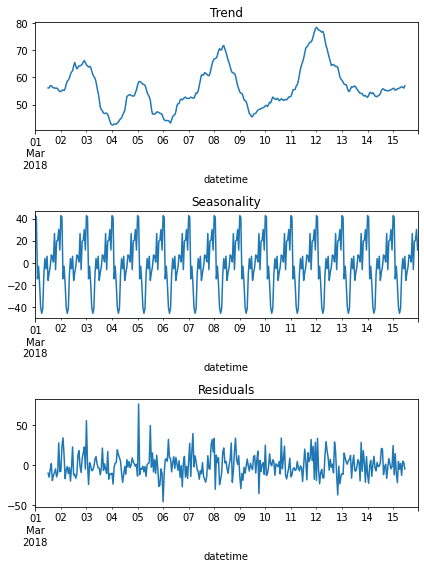

In [48]:
# разложим временной ряд на тренд и сезонную компоненту за первые 15 дней марта 2018 года.
decomposed = seasonal_decompose(df['2018-03-01':'2018-03-15'])
plt.figure(figsize=(6, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

##### Вывод:
- дисперсия ряда всего датасета со временем увеличивается, временной ряд не является стационарным
- по тренду видно, что со временем все больше людей пользуется услугами такси
- при разложении за первые 15 дней марта 2018 года видно, что наибольшим спросом такси пользуется в понедельник и субботу

##### Напишим функцию make_features() , чтобы прибавить к таблице четыре новых  признака: месяц, день, день недели и час, т.к. прослеживается активность по часам тоже, прибавить `lag`, `rolling`

In [49]:
def make_features(df, max_lag, rolling_mean_size):
    df = df.copy(deep=True)
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df

In [50]:
def rmse(first_list, second_list): # добавим функцию дл явычисления RMSE
    return np.sqrt(mean_squared_error(first_list, second_list))

<a id="3"></a>

### 3. Обучим модели.

##### LinearRegression

Определим количество lag признаков: найдем разницу в часах между максимальным пиком и минимальным уровнем в течении 24 часов

In [51]:
df_day = seasonal_decompose(df['2018-03-01':'2018-03-02'])
lag_max = (df_day.seasonal.idxmax() - df_day.seasonal.idxmin()) 
           
lag_max

Timedelta('-1 days +18:00:00')

`rolling`

In [52]:
best_rmse = 48
for log in range(47, 50):
    for rsz in range(2, 5):
        df_find = make_features(df, log, rsz)

        lr_df, test = train_test_split(df_find, shuffle=False, test_size=0.1)
        train, valid = train_test_split(lr_df, shuffle=False, test_size=0.25)
        train = train.dropna()
        features_train = train.drop('num_orders', axis=1)
        target_train = train['num_orders']

        features_valid = valid.drop('num_orders', axis=1)
        target_valid = valid['num_orders']

        lin_reg = LinearRegression()
        lin_reg.fit(features_train, target_train)

        pred = lin_reg.predict(features_valid)

        current_rmse = rmse(pred, target_valid)
        if current_rmse < best_rmse:
            best_rmse = current_rmse
            best_rsz = rsz
            best_log = log
print("RMSE:", best_rmse, "\nrolling_sum:", best_rsz, "\nlog:", best_log)


RMSE: 29.506693921454886 
rolling_sum: 2 
log: 48


In [53]:
lr_df = make_features(df, 48, 2) 

train, test = train_test_split(lr_df, shuffle=False, test_size=0.1)
train.dropna(inplace=True)
test.dropna(inplace=True)

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [54]:
target_train

datetime
2018-03-03 00:00:00    163
2018-03-03 01:00:00    108
2018-03-03 02:00:00     25
2018-03-03 03:00:00     64
2018-03-03 04:00:00     44
                      ... 
2018-08-13 09:00:00    137
2018-08-13 10:00:00    156
2018-08-13 11:00:00    144
2018-08-13 12:00:00     92
2018-08-13 13:00:00    119
Freq: H, Name: num_orders, Length: 3926, dtype: int64

##### Cat Boost

In [55]:

modelCat = CatBoostRegressor( random_state = 12345)
hyperparams = [{'depth' : [3], #брал 1, 2, 3
                'learning_rate' : [0.1], #брал 0.03, 0.06, 0.1
                'iterations' : [300], #брал 100, 200, 300
                'verbose' : [False]
               }]
my_cv=TimeSeriesSplit(n_splits=3).split(features_train)
clf = GridSearchCV(modelCat, hyperparams, cv=my_cv, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)
best_params_CBR = clf.best_params_
print(best_params_CBR)
print((clf.best_score_*-1)**0.5)


{'depth': 3, 'iterations': 300, 'learning_rate': 0.1, 'verbose': False}
25.142633104780565


##### LGBMRegressor

In [56]:
LGBMR = LGBMRegressor() 
hyperparams = [{'depth' : [3],
                'learning_rate':[0.03],
                'verbose' : [10],
                'random_state':[12345]}]

my_cv=TimeSeriesSplit(n_splits=3).split(features_train)
clf = GridSearchCV(modelCat, hyperparams, cv=my_cv, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)

0:	learn: 28.8728318	total: 2.51ms	remaining: 2.51s
10:	learn: 25.9052770	total: 26.2ms	remaining: 2.36s
20:	learn: 23.7713862	total: 47.7ms	remaining: 2.22s
30:	learn: 22.1760703	total: 67.4ms	remaining: 2.11s
40:	learn: 20.9727319	total: 88.8ms	remaining: 2.08s
50:	learn: 20.1502080	total: 116ms	remaining: 2.15s
60:	learn: 19.5480647	total: 136ms	remaining: 2.1s
70:	learn: 19.0844974	total: 160ms	remaining: 2.09s
80:	learn: 18.7180884	total: 184ms	remaining: 2.09s
90:	learn: 18.4256215	total: 217ms	remaining: 2.16s
100:	learn: 18.1231381	total: 237ms	remaining: 2.11s
110:	learn: 17.8916149	total: 259ms	remaining: 2.08s
120:	learn: 17.6547532	total: 286ms	remaining: 2.08s
130:	learn: 17.4842690	total: 309ms	remaining: 2.05s
140:	learn: 17.3122455	total: 329ms	remaining: 2s
150:	learn: 17.1432932	total: 350ms	remaining: 1.97s
160:	learn: 17.0556676	total: 371ms	remaining: 1.93s
170:	learn: 16.8932557	total: 398ms	remaining: 1.93s
180:	learn: 16.7698268	total: 421ms	remaining: 1.91s
190

560:	learn: 15.8649077	total: 1.54s	remaining: 1.2s
570:	learn: 15.8071580	total: 1.56s	remaining: 1.18s
580:	learn: 15.7515972	total: 1.59s	remaining: 1.15s
590:	learn: 15.6851233	total: 1.62s	remaining: 1.12s
600:	learn: 15.6268149	total: 1.64s	remaining: 1.09s
610:	learn: 15.5791515	total: 1.67s	remaining: 1.06s
620:	learn: 15.5272735	total: 1.69s	remaining: 1.03s
630:	learn: 15.4790963	total: 1.72s	remaining: 1s
640:	learn: 15.4238176	total: 1.75s	remaining: 980ms
650:	learn: 15.3812840	total: 1.77s	remaining: 952ms
660:	learn: 15.3317748	total: 1.8s	remaining: 924ms
670:	learn: 15.2878192	total: 1.83s	remaining: 895ms
680:	learn: 15.2336589	total: 1.85s	remaining: 867ms
690:	learn: 15.1762435	total: 1.88s	remaining: 840ms
700:	learn: 15.1326395	total: 1.91s	remaining: 814ms
710:	learn: 15.0794149	total: 1.93s	remaining: 786ms
720:	learn: 15.0375295	total: 1.96s	remaining: 758ms
730:	learn: 14.9961905	total: 1.98s	remaining: 730ms
740:	learn: 14.9457382	total: 2.01s	remaining: 702m

120:	learn: 23.5848407	total: 437ms	remaining: 3.18s
130:	learn: 23.4271560	total: 471ms	remaining: 3.12s
140:	learn: 23.2872835	total: 504ms	remaining: 3.07s
150:	learn: 23.1492879	total: 537ms	remaining: 3.02s
160:	learn: 23.0342600	total: 571ms	remaining: 2.97s
170:	learn: 22.9116478	total: 604ms	remaining: 2.93s
180:	learn: 22.8080574	total: 638ms	remaining: 2.89s
190:	learn: 22.7223706	total: 671ms	remaining: 2.84s
200:	learn: 22.6539999	total: 704ms	remaining: 2.8s
210:	learn: 22.6007595	total: 736ms	remaining: 2.75s
220:	learn: 22.5339748	total: 769ms	remaining: 2.71s
230:	learn: 22.4445488	total: 803ms	remaining: 2.67s
240:	learn: 22.3500879	total: 838ms	remaining: 2.64s
250:	learn: 22.2625651	total: 871ms	remaining: 2.6s
260:	learn: 22.1943993	total: 904ms	remaining: 2.56s
270:	learn: 22.1313386	total: 938ms	remaining: 2.52s
280:	learn: 22.0448702	total: 972ms	remaining: 2.49s
290:	learn: 21.9698215	total: 1s	remaining: 2.45s
300:	learn: 21.8901145	total: 1.04s	remaining: 2.41

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000000000DF8E120>,
             estimator=<catboost.core.CatBoostRegressor object at 0x000000000DF766D0>,
             param_grid=[{'depth': [3], 'learning_rate': [0.03],
                          'random_state': [12345], 'verbose': [10]}],
             scoring='neg_mean_squared_error')

In [57]:
print(clf.best_params_)
print((clf.best_score_*-1)**0.5)

{'depth': 3, 'learning_rate': 0.03, 'random_state': 12345, 'verbose': 10}
25.123623345287303


<a id="4"></a>

### 4. Тестирование моделей.

##### LinearRegression

RMSE test: 43.15795727944441


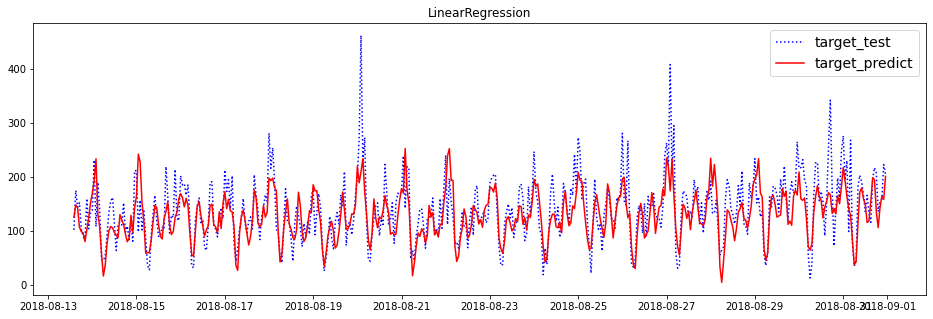

In [58]:
model = LinearRegression()
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
rmse_lr = mean_squared_error(target_test, target_predict) ** 0.5
print('RMSE test:', rmse_lr)

plt.figure(figsize=(16, 5))
plt.title('LinearRegression')
plt.plot(target_test.index, target_test, ':b', label='target_test')
plt.plot(target_test.index, target_predict, '-r', label='target_predict')
plt.legend(fontsize=14)

##### Cat Boost

RMSE test: 41.2307073915989


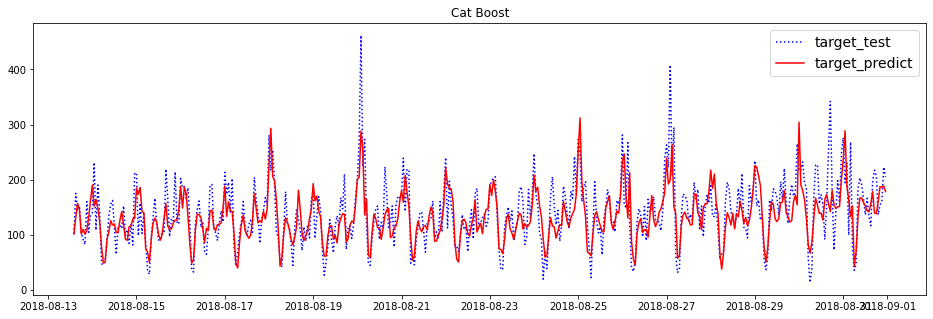

In [59]:
modelCat = CatBoostRegressor(depth = 3, iterations = 300, learning_rate = 0.1, verbose= False)
modelCat.fit(features_train, target_train)
target_predict = modelCat.predict(features_test)
rmse_cbr = mean_squared_error(target_test, target_predict) ** 0.5
print('RMSE test:', rmse_cbr)

plt.figure(figsize=(16, 5))
plt.title('Cat Boost')
plt.plot(target_test.index, target_test, ':b', label='target_test')
plt.plot(target_test.index, target_predict, '-r', label='target_predict')
plt.legend(fontsize=14)

##### LGBMRegressor

RMSE test: 41.56612914028503


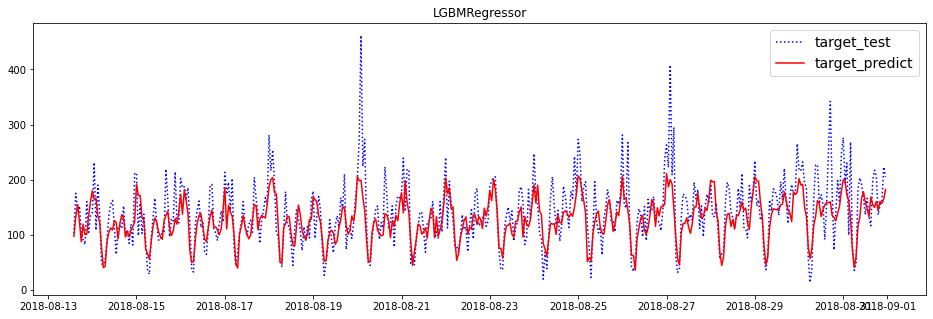

In [60]:
LGBMR = LGBMRegressor(depth = 3, learning_rate = 0.03, random_state = 12345, verbose = 10)
LGBMR.fit(features_train, target_train)
target_predict = LGBMR.predict(features_test)
rmse_LGBMR = mean_squared_error(target_test, target_predict) ** 0.5
print('RMSE test:', rmse_LGBMR)

plt.figure(figsize=(16, 5))
plt.title('LGBMRegressor')
plt.plot(target_test.index, target_test, ':b', label='target_test')
plt.plot(target_test.index, target_predict, '-r', label='target_predict')
plt.legend(fontsize=14)

In [61]:
data = [rmse_lr,
        rmse_cbr,
        rmse_LGBMR]
model = ['Linear Regression', 'CatBoostRegressor', 'LGBMRegressor']
pd.DataFrame(data=data, index=model, columns=['RMSE test'])

,RMSE test
Linear Regression,43.157957
CatBoostRegressor,41.230707
LGBMRegressor,41.566129


#### Вывод:
- по итогам тестирования моделей, лучше всего предсказала ряд `CatBoostRegressor` c ошибкой 41.23 в час

### Вывод:

В ходе проделанной работы было выполнено:

- Загрузили и изучили данные,выполнили их ресемплирование по одному часу.
- Проанализировали данные, провели декомпозицию на всем датафрейме и на небольшом временном отрезке, визуализировали это.
- Обучили три модели с различными гиперпараметрами: `LinearRegression`, `Cat Boost` и `LGBMRegressor`.
- Провели тестирование моделей и нашли наилучшую модель для предсказания - `CatBoostRegressor` c ошибкой 41.23 в час


##### [к оглавлению](#up)